# Model Training, Optimization, and Validation

#### Objectives
- Write your notebook objective here, for example, "Fetch data from Kaggle and save as raw data", or "engineer features for modelling"

#### Inputs
- Write here which data or information you need to run the notebook 

#### Outputs
- Write here which files, code or artefacts you generate by the end of the notebook 

#### Additional Comments
- In case you have any additional comments that don't fit in the previous bullets, please state them here. 


---

## 1. Basic setup

#### Import libraries

In [1]:
import os
import dotenv
import joblib
import lightgbm as lgb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import xgboost as xgb

from bisect import bisect_right
from time import time
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import RandomizedSearchCV, ShuffleSplit, train_test_split

#### Load environment variables.

In [2]:
dotenv.load_dotenv()

True

#### File paths

In [3]:
def get_path(filename):
    return os.path.join(os.getenv("LOCAL_DATASET_PATH"), filename)

data_dictionary_path = get_path(os.getenv("HOUSING_DATA_DICTIONARY"))
housing_records_path = get_path(os.getenv("HOUSING_RECORDS_FILENAME"))
inherited_houses_path = get_path(os.getenv("INHERITED_HOUSES_FILENAME"))
na_stat_housing_records_path = get_path(os.getenv("NA_STATS_HOUSING_RECORDS_FILENAME"))
correlated_variables_path = get_path(os.getenv("CORRELATED_VARIABLE_FILES"))
estimator_path = get_path(os.getenv("HOUSING_ESTIMATOR_NAME"))
prediction_subset_path = get_path(os.getenv("PREDICTION_SUBSET_FILENAME"))
prediction_features_path = get_path(os.getenv("PREDICTION_FEATURES_FILENAME"))
optimisation_performance_path = get_path( os.getenv("OPTIMISATION_PERFORMANCE_FILENAME"))
optimisation_feature_importance_path = get_path(os.getenv("OPTIMISATION_FEATURES_IMPORTANCE_FILENAME"))
optimisation_parameters_path = get_path( os.getenv("OPT_PARAMETERS_FILENAME"))
model_performance_path = get_path(os.getenv("MODEL_PERFORMANCE_FILENAME"))
model_feature_importance_path = get_path(os.getenv("MODEL_FEATURES_IMPORTANCE_FILENAME"))
model_parameters_path = get_path( os.getenv("MODEL_PARAMETERS_FILENAME"))
learning_curve_path = get_path(os.getenv("LEARNING_CURVE_FILENAME"))

#### Other parameters

In [4]:
housing_records_rows = 1460 
housing_records_columns = 24
target_column = "SalePrice"
random_state = 1234

## 2. Data Loading

#### Housing records

In [5]:
housing_records = pd.read_csv(housing_records_path)
assert housing_records.shape == (housing_records_rows, housing_records_columns)
display(housing_records)

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd,SalePrice
0,856,854.0,3.0,No,706,GLQ,150,0.0,548,RFn,...,65.0,196.0,61,5,7,856,0.0,2003,2003,208500
1,1262,0.0,3.0,Gd,978,ALQ,284,NaN,460,RFn,...,80.0,0.0,0,8,6,1262,NaN,1976,1976,181500
2,920,866.0,3.0,Mn,486,GLQ,434,0.0,608,RFn,...,68.0,162.0,42,5,7,920,NaN,2001,2002,223500
3,961,NaN,NaN,No,216,ALQ,540,NaN,642,Unf,...,60.0,0.0,35,5,7,756,NaN,1915,1970,140000
4,1145,NaN,4.0,Av,655,GLQ,490,0.0,836,RFn,...,84.0,350.0,84,5,8,1145,NaN,2000,2000,250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1455,953,694.0,3.0,No,0,Unf,953,NaN,460,RFn,...,62.0,0.0,40,5,6,953,0.0,1999,2000,175000
1456,2073,0.0,NaN,No,790,ALQ,589,NaN,500,Unf,...,85.0,119.0,0,6,6,1542,NaN,1978,1988,210000
1457,1188,1152.0,4.0,No,275,GLQ,877,NaN,252,RFn,...,66.0,0.0,60,9,7,1152,NaN,1941,2006,266500
1458,1078,0.0,2.0,Mn,49,NaN,0,112.0,240,Unf,...,68.0,0.0,0,6,5,1078,NaN,1950,1996,142125


In [6]:
na_data = pd.read_csv(na_stat_housing_records_path)
display(na_data)

,column,count,percentage,should_remove
0,EnclosedPorch,1324,90.68,True
1,WoodDeckSF,1305,89.38,True
2,LotFrontage,259,17.74,True
3,GarageFinish,235,16.10,True
4,BsmtFinType1,145,9.93,False
5,BedroomAbvGr,99,6.78,False
6,2ndFlrSF,86,5.89,False
7,GarageYrBlt,81,5.55,False
8,BsmtExposure,38,2.60,False
9,MasVnrArea,8,0.55,False


### Inherited houses

In [7]:
inherited_houses = pd.read_csv(inherited_houses_path)
assert inherited_houses.shape == (4, 23)
inherited_houses.head()

,1stFlrSF,2ndFlrSF,BedroomAbvGr,BsmtExposure,BsmtFinSF1,BsmtFinType1,BsmtUnfSF,EnclosedPorch,GarageArea,GarageFinish,...,LotArea,LotFrontage,MasVnrArea,OpenPorchSF,OverallCond,OverallQual,TotalBsmtSF,WoodDeckSF,YearBuilt,YearRemodAdd
0,896,0,2,No,468.0,Rec,270.0,0,730.0,Unf,...,11622,80.0,0.0,0,6,5,882.0,140,1961,1961
1,1329,0,3,No,923.0,ALQ,406.0,0,312.0,Unf,...,14267,81.0,108.0,36,6,6,1329.0,393,1958,1958
2,928,701,3,No,791.0,GLQ,137.0,0,482.0,Fin,...,13830,74.0,0.0,34,5,5,928.0,212,1997,1998
3,926,678,3,No,602.0,GLQ,324.0,0,470.0,Fin,...,9978,78.0,20.0,36,6,6,926.0,360,1998,1998


### Correlated variables

In [8]:
correlated_variables = pd.read_csv(correlated_variables_path)
correlated_variables

,featureName,featureType,featureDescription,featureValues
0,1stFlrSF,numerical,First Floor square feet,334 - 4692
1,TotalBsmtSF,numerical,Total square feet of basement area,0 - 6110
2,GarageArea,numerical,Size of garage in square feet,0 - 1418
3,KitchenQual,categorical,Kitchen quality,"Ex: Excellent, Gd: Good, TA: Typical/Average, ..."
4,OverallCond,categorical,Rates the overall condition of the house,"10: Very Excellent, 9: Excellent, 8: Very Good..."
5,OverallQual,categorical,Rates the overall material and finish of the ...,"10: Very Excellent, 9: Excellent, 8: Very Good..."
6,YearBuilt,temporal,Original construction date,1872 - 2010
7,YearRemodAdd,temporal,Remodel date (same as construction date if no...,1950 - 2010


In [9]:
categorical_feature_names = correlated_variables[
    correlated_variables["featureType"] == "categorical"
]["featureName"].to_list()

print(categorical_feature_names)

['KitchenQual', 'OverallCond', 'OverallQual']


In [10]:
numerical_feature_names = correlated_variables[
    correlated_variables["featureType"] == "numerical"
]["featureName"].to_list()

print(numerical_feature_names)

['1stFlrSF', 'TotalBsmtSF', 'GarageArea']


In [11]:
temporal_feature_names = correlated_variables[
    correlated_variables["featureType"] == "temporal"
]["featureName"].to_list()

print(temporal_feature_names)

['YearBuilt', 'YearRemodAdd']


---

## 3. Feature engineering

### Data subset for feature engineering

In [12]:
necessary_columns = categorical_feature_names + numerical_feature_names + temporal_feature_names
necessary_columns

['KitchenQual',
 'OverallCond',
 'OverallQual',
 '1stFlrSF',
 'TotalBsmtSF',
 'GarageArea',
 'YearBuilt',
 'YearRemodAdd']

In [13]:
training_subset = housing_records[necessary_columns]
assert training_subset.shape == (housing_records_rows, len(necessary_columns))
training_subset.head()

,KitchenQual,OverallCond,OverallQual,1stFlrSF,TotalBsmtSF,GarageArea,YearBuilt,YearRemodAdd
0,Gd,5,7,856,856,548,2003,2003
1,TA,8,6,1262,1262,460,1976,1976
2,Gd,5,7,920,920,608,2001,2002
3,Gd,5,7,961,756,642,1915,1970
4,Gd,5,8,1145,1145,836,2000,2000


In [14]:
prediction_subset = inherited_houses[necessary_columns]
assert prediction_subset.shape == (inherited_houses.shape[0], len(necessary_columns))
prediction_subset.head()

,KitchenQual,OverallCond,OverallQual,1stFlrSF,TotalBsmtSF,GarageArea,YearBuilt,YearRemodAdd
0,TA,6,5,896,882.0,730.0,1961,1961
1,Gd,6,6,1329,1329.0,312.0,1958,1958
2,TA,5,5,928,928.0,482.0,1997,1998
3,Gd,6,6,926,926.0,470.0,1998,1998


### Training Data

#### Target Data

In [15]:
target = housing_records[target_column]
assert target.shape[0] == housing_records_rows
target.describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

##### Calculate basis for aggregate features
We create bins for house sale prices over which we will agreegate numerical and categorical features

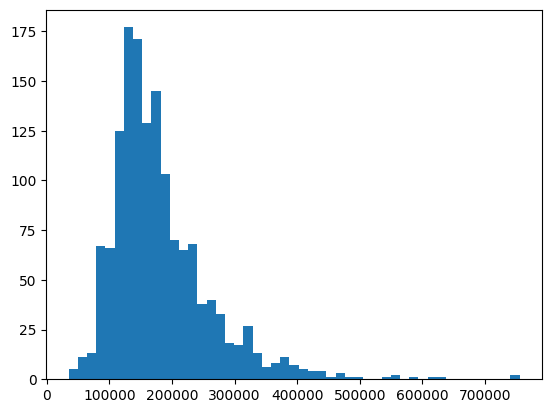

In [16]:
hist = plt.hist(target, bins="auto")
plt.show()

In [17]:
def find_nearest(inp, value_range):
    right = bisect_right(value_range, inp)
    if right == 0:
        bounds = value_range[right]
    elif right == len(value_range):
        bounds = value_range[right - 1]
    elif inp >= value_range[right - 1] and inp <= value_range[right]:
        bounds = value_range[right - 1] 

    return round(bounds)

assert find_nearest(inp=223500, value_range=hist[1]) == 211251

In [18]:
target_column_bin_name = f"{target_column}Bin"
target_bin = pd.DataFrame(
    target.apply(find_nearest, args=(hist[1],))
)
target_bin.columns = [target_column_bin_name]
target_bin.head()

,SalePriceBin
0,196555
1,167163
2,211251
3,137771
4,240643


In [19]:
target_with_bin = pd.DataFrame(pd.concat([target, target_bin], axis=1))
target_with_bin.head()

,SalePrice,SalePriceBin
0,208500,196555
1,181500,167163
2,223500,211251
3,140000,137771
4,250000,240643


#### Categorical features

In [20]:
housing_records_categorical = training_subset[categorical_feature_names]
housing_records_categorical = housing_records_categorical.astype({
    var: "object" for var in categorical_feature_names
})
assert housing_records_categorical.shape == (housing_records_rows, len(categorical_feature_names))
housing_records_categorical.head()

,KitchenQual,OverallCond,OverallQual
0,Gd,5,7
1,TA,8,6
2,Gd,5,7
3,Gd,5,7
4,Gd,5,8


In [21]:
housing_categorical = pd.concat([pd.get_dummies(housing_records_categorical), target_bin], axis=1)\
    .groupby(target_column_bin_name)\
    .agg(["sum", "mean"])
housing_categorical.columns = ["_".join(_) for _ in housing_categorical.columns]
housing_categorical.reset_index()
print(housing_categorical.shape)
housing_categorical.head()

(39, 46)


,KitchenQual_Ex_sum,KitchenQual_Ex_mean,KitchenQual_Fa_sum,KitchenQual_Fa_mean,KitchenQual_Gd_sum,KitchenQual_Gd_mean,KitchenQual_TA_sum,KitchenQual_TA_mean,OverallCond_1_sum,OverallCond_1_mean,...,OverallQual_6_sum,OverallQual_6_mean,OverallQual_7_sum,OverallQual_7_mean,OverallQual_8_sum,OverallQual_8_mean,OverallQual_9_sum,OverallQual_9_mean,OverallQual_10_sum,OverallQual_10_mean
SalePriceBin,,,,,,,,,,,,,,,,,,,,,
34900,0,0.000000,1,0.200000,0,0.000000,4,0.800000,0,0.000000,...,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0
49596,0,0.000000,6,0.545455,0,0.000000,5,0.454545,1,0.090909,...,0,0.000000,0,0.000000,0,0.0,0,0.0,0,0.0
64292,0,0.000000,2,0.153846,0,0.000000,11,0.846154,0,0.000000,...,1,0.076923,0,0.000000,0,0.0,0,0.0,0,0.0
78988,2,0.029851,7,0.104478,5,0.074627,53,0.791045,0,0.000000,...,10,0.149254,1,0.014925,0,0.0,0,0.0,0,0.0
93684,0,0.000000,2,0.030303,2,0.030303,62,0.939394,0,0.000000,...,12,0.181818,0,0.000000,0,0.0,0,0.0,0,0.0


In [22]:
target_with_categorical = target_with_bin.merge(
    housing_categorical, 
    left_on=target_column_bin_name, 
    right_index=True,
    how="left"
)
target_with_categorical.head()

,SalePrice,SalePriceBin,KitchenQual_Ex_sum,KitchenQual_Ex_mean,KitchenQual_Fa_sum,KitchenQual_Fa_mean,KitchenQual_Gd_sum,KitchenQual_Gd_mean,KitchenQual_TA_sum,KitchenQual_TA_mean,...,OverallQual_6_sum,OverallQual_6_mean,OverallQual_7_sum,OverallQual_7_mean,OverallQual_8_sum,OverallQual_8_mean,OverallQual_9_sum,OverallQual_9_mean,OverallQual_10_sum,OverallQual_10_mean
0,208500,196555,2,0.028571,1,0.014286,48,0.685714,19,0.271429,...,22,0.314286,38,0.542857,6,0.085714,0,0.0,0,0.0
1,181500,167163,4,0.027586,1,0.006897,69,0.475862,71,0.489655,...,72,0.496552,43,0.296552,7,0.048276,0,0.0,0,0.0
2,223500,211251,1,0.015385,0,0.000000,58,0.892308,6,0.092308,...,12,0.184615,41,0.630769,8,0.123077,0,0.0,0,0.0
3,140000,137771,2,0.011696,3,0.017544,39,0.228070,127,0.742690,...,62,0.362573,16,0.093567,1,0.005848,0,0.0,0,0.0
4,250000,240643,4,0.105263,0,0.000000,29,0.763158,5,0.131579,...,3,0.078947,19,0.500000,16,0.421053,0,0.0,0,0.0


#### Numercial features

In [23]:
housing_records_numerical = training_subset[numerical_feature_names]
housing_records_numerical = housing_records_numerical.astype({
    var: "float" for var in numerical_feature_names
})
assert housing_records_categorical.shape == (housing_records_rows, len(numerical_feature_names))
housing_records_numerical.head()

,1stFlrSF,TotalBsmtSF,GarageArea
0,856.0,856.0,548.0
1,1262.0,1262.0,460.0
2,920.0,920.0,608.0
3,961.0,756.0,642.0
4,1145.0,1145.0,836.0


In [24]:
housing_numerical = pd.concat([housing_records_numerical, target_bin], axis=1)\
    .groupby(target_column_bin_name)\
    .agg(["count", "mean", "max", "min", "sum"])
housing_numerical.columns = ["_".join(_) for _ in housing_numerical.columns]
housing_numerical.reset_index()
print(housing_numerical.shape)
housing_numerical.head()

(39, 15)


,1stFlrSF_count,1stFlrSF_mean,1stFlrSF_max,1stFlrSF_min,1stFlrSF_sum,TotalBsmtSF_count,TotalBsmtSF_mean,TotalBsmtSF_max,TotalBsmtSF_min,TotalBsmtSF_sum,GarageArea_count,GarageArea_mean,GarageArea_max,GarageArea_min,GarageArea_sum
SalePriceBin,,,,,,,,,,,,,,,
34900,5,556.600000,720.0,334.0,2783.0,5,489.800000,720.0,0.0,2449.0,5,111.600000,308.0,0.0,558.0
49596,11,798.181818,1276.0,372.0,8780.0,11,594.545455,1276.0,0.0,6540.0,11,150.909091,504.0,0.0,1660.0
64292,13,780.692308,1306.0,520.0,10149.0,13,641.461538,961.0,0.0,8339.0,13,242.153846,528.0,0.0,3148.0
78988,67,837.432836,1422.0,483.0,56108.0,67,585.417910,1386.0,0.0,39223.0,67,247.208955,1248.0,0.0,16563.0
93684,66,897.136364,1664.0,483.0,59211.0,66,693.772727,1235.0,0.0,45789.0,66,297.575758,936.0,0.0,19640.0


In [25]:
training_features = target_with_categorical.merge(
    housing_numerical, 
    left_on=target_column_bin_name, 
    right_index=True, 
    how="left"
)
training_features.head()

,SalePrice,SalePriceBin,KitchenQual_Ex_sum,KitchenQual_Ex_mean,KitchenQual_Fa_sum,KitchenQual_Fa_mean,KitchenQual_Gd_sum,KitchenQual_Gd_mean,KitchenQual_TA_sum,KitchenQual_TA_mean,...,TotalBsmtSF_count,TotalBsmtSF_mean,TotalBsmtSF_max,TotalBsmtSF_min,TotalBsmtSF_sum,GarageArea_count,GarageArea_mean,GarageArea_max,GarageArea_min,GarageArea_sum
0,208500,196555,2,0.028571,1,0.014286,48,0.685714,19,0.271429,...,70,1147.442857,2035.0,0.0,80321.0,70,529.742857,968.0,0.0,37082.0
1,181500,167163,4,0.027586,1,0.006897,69,0.475862,71,0.489655,...,145,1010.979310,1947.0,0.0,146592.0,145,479.917241,1356.0,0.0,69588.0
2,223500,211251,1,0.015385,0,0.000000,58,0.892308,6,0.092308,...,65,1182.753846,1860.0,700.0,76879.0,65,539.692308,924.0,230.0,35080.0
3,140000,137771,2,0.011696,3,0.017544,39,0.228070,127,0.742690,...,171,975.058480,2136.0,0.0,166735.0,171,434.654971,923.0,0.0,74326.0
4,250000,240643,4,0.105263,0,0.000000,29,0.763158,5,0.131579,...,38,1315.184211,2223.0,585.0,49977.0,38,659.552632,1390.0,180.0,25063.0


#### Temporal features

In [26]:
housing_records_temporal = training_subset[temporal_feature_names]
assert housing_records_temporal.shape == (housing_records_rows, len(temporal_feature_names))
housing_records_temporal.head()

,YearBuilt,YearRemodAdd
0,2003,2003
1,1976,1976
2,2001,2002
3,1915,1970
4,2000,2000


In [27]:
latest_years_built = max(housing_records_temporal["YearBuilt"])
training_features.loc[:, "NumYearsSinceBuilt"] = latest_years_built - housing_records_temporal["YearBuilt"]
training_features.loc[:, "NumYearsSinceRemodelled"] = latest_years_built - housing_records_temporal["YearRemodAdd"]
training_features.head()

,SalePrice,SalePriceBin,KitchenQual_Ex_sum,KitchenQual_Ex_mean,KitchenQual_Fa_sum,KitchenQual_Fa_mean,KitchenQual_Gd_sum,KitchenQual_Gd_mean,KitchenQual_TA_sum,KitchenQual_TA_mean,...,TotalBsmtSF_max,TotalBsmtSF_min,TotalBsmtSF_sum,GarageArea_count,GarageArea_mean,GarageArea_max,GarageArea_min,GarageArea_sum,NumYearsSinceBuilt,NumYearsSinceRemodelled
0,208500,196555,2,0.028571,1,0.014286,48,0.685714,19,0.271429,...,2035.0,0.0,80321.0,70,529.742857,968.0,0.0,37082.0,7,7
1,181500,167163,4,0.027586,1,0.006897,69,0.475862,71,0.489655,...,1947.0,0.0,146592.0,145,479.917241,1356.0,0.0,69588.0,34,34
2,223500,211251,1,0.015385,0,0.000000,58,0.892308,6,0.092308,...,1860.0,700.0,76879.0,65,539.692308,924.0,230.0,35080.0,9,8
3,140000,137771,2,0.011696,3,0.017544,39,0.228070,127,0.742690,...,2136.0,0.0,166735.0,171,434.654971,923.0,0.0,74326.0,95,40
4,250000,240643,4,0.105263,0,0.000000,29,0.763158,5,0.131579,...,2223.0,585.0,49977.0,38,659.552632,1390.0,180.0,25063.0,10,10


In [28]:
training_features = training_features.drop(target_column_bin_name, axis=1)
assert training_features.shape

In [29]:
assert training_features.isna().sum().sum() == 0

### Split train, test, validation 

In [30]:
features_train, features_test = train_test_split(training_features, test_size=0.2)
features_cv, _ = train_test_split(features_train, test_size=0.5)

assert features_train.shape[0] == training_features.shape[0] * 0.8
assert features_cv.shape[0] == training_features.shape[0] * 0.8 * 0.5
assert features_test.shape[0] == training_features.shape[0] * 0.2

X_cv = features_cv.drop(target_column, axis=1)  # use during hyper parameter optimisation
y_cv = features_cv[target_column]

X_train = features_train.drop(target_column, axis=1)  # to train model using best hyper parameters
y_train = features_train[target_column]

X_test = features_test.drop(target_column, axis=1)  # to test best hyper parameter model
y_test = features_test[target_column]

data_columns = features_train.columns

---

### Prediction Features

#### Categorical features

In [31]:
inherited_houses_categorical = prediction_subset[categorical_feature_names]
inherited_houses_categorical = inherited_houses_categorical.astype({
    var: "object" for var in categorical_feature_names
})
assert inherited_houses_categorical.shape == (prediction_subset.shape[0], len(categorical_feature_names))
inherited_houses_categorical.head()

,KitchenQual,OverallCond,OverallQual
0,TA,6,5
1,Gd,6,6
2,TA,5,5
3,Gd,6,6


In [32]:
inherited_categorical = pd.get_dummies(inherited_houses_categorical).groupby(level=0).agg(["sum", "mean"])
inherited_categorical.columns = ["_".join(_) for _ in inherited_categorical.columns]
inherited_categorical.reset_index()
missing_cols = housing_categorical.columns.difference(inherited_categorical.columns)
inherited_categorical.loc[:, missing_cols] = 0
assert inherited_categorical.shape[1] == housing_categorical.shape[1]
inherited_categorical.head()

,KitchenQual_Gd_sum,KitchenQual_Gd_mean,KitchenQual_TA_sum,KitchenQual_TA_mean,OverallCond_5_sum,OverallCond_5_mean,OverallCond_6_sum,OverallCond_6_mean,OverallQual_5_sum,OverallQual_5_mean,...,OverallQual_3_mean,OverallQual_3_sum,OverallQual_4_mean,OverallQual_4_sum,OverallQual_7_mean,OverallQual_7_sum,OverallQual_8_mean,OverallQual_8_sum,OverallQual_9_mean,OverallQual_9_sum
0,0,0.0,1,1.0,0,0.0,1,1.0,1,1.0,...,0,0,0,0,0,0,0,0,0,0
1,1,1.0,0,0.0,0,0.0,1,1.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,0,0.0,1,1.0,1,1.0,0,0.0,1,1.0,...,0,0,0,0,0,0,0,0,0,0
3,1,1.0,0,0.0,0,0.0,1,1.0,0,0.0,...,0,0,0,0,0,0,0,0,0,0


#### Numerical features

In [33]:
inherited_houses_numerical = prediction_subset[numerical_feature_names]
inherited_houses_numerical = inherited_houses_numerical.astype({
    var: "float" for var in numerical_feature_names
})
assert inherited_houses_numerical.shape == (prediction_subset.shape[0], len(numerical_feature_names))
inherited_houses_numerical.head()

,1stFlrSF,TotalBsmtSF,GarageArea
0,896.0,882.0,730.0
1,1329.0,1329.0,312.0
2,928.0,928.0,482.0
3,926.0,926.0,470.0


In [34]:
inherited_numerical = inherited_houses_numerical\
    .groupby(level=0)\
    .agg(["count", "mean", "max", "min", "sum"])
inherited_numerical.columns = ["_".join(_) for _ in inherited_numerical.columns]
inherited_numerical.reset_index()
assert inherited_numerical.shape[1] == housing_numerical.shape[1]
inherited_numerical.head()

,1stFlrSF_count,1stFlrSF_mean,1stFlrSF_max,1stFlrSF_min,1stFlrSF_sum,TotalBsmtSF_count,TotalBsmtSF_mean,TotalBsmtSF_max,TotalBsmtSF_min,TotalBsmtSF_sum,GarageArea_count,GarageArea_mean,GarageArea_max,GarageArea_min,GarageArea_sum
0,1,896.0,896.0,896.0,896.0,1,882.0,882.0,882.0,882.0,1,730.0,730.0,730.0,730.0
1,1,1329.0,1329.0,1329.0,1329.0,1,1329.0,1329.0,1329.0,1329.0,1,312.0,312.0,312.0,312.0
2,1,928.0,928.0,928.0,928.0,1,928.0,928.0,928.0,928.0,1,482.0,482.0,482.0,482.0
3,1,926.0,926.0,926.0,926.0,1,926.0,926.0,926.0,926.0,1,470.0,470.0,470.0,470.0


### Temporal features

In [35]:
inherited_houses_temporal = prediction_subset[temporal_feature_names]
assert inherited_houses_temporal.shape == (prediction_subset.shape[0], len(temporal_feature_names))
inherited_houses_temporal.head()

,YearBuilt,YearRemodAdd
0,1961,1961
1,1958,1958
2,1997,1998
3,1998,1998


In [36]:
prediction_features = pd.concat([inherited_categorical, inherited_numerical], axis=1)
prediction_features.loc[:, "NumYearsSinceBuilt"] = latest_years_built - inherited_houses_temporal["YearBuilt"]
prediction_features.loc[:, "NumYearsSinceRemodelled"] = latest_years_built - inherited_houses_temporal["YearRemodAdd"]
prediction_features = prediction_features.reindex(columns=X_train.columns)
prediction_features.head()

,KitchenQual_Ex_sum,KitchenQual_Ex_mean,KitchenQual_Fa_sum,KitchenQual_Fa_mean,KitchenQual_Gd_sum,KitchenQual_Gd_mean,KitchenQual_TA_sum,KitchenQual_TA_mean,OverallCond_1_sum,OverallCond_1_mean,...,TotalBsmtSF_max,TotalBsmtSF_min,TotalBsmtSF_sum,GarageArea_count,GarageArea_mean,GarageArea_max,GarageArea_min,GarageArea_sum,NumYearsSinceBuilt,NumYearsSinceRemodelled
0,0,0,0,0,0,0.0,1,1.0,0,0,...,882.0,882.0,882.0,1,730.0,730.0,730.0,730.0,49,49
1,0,0,0,0,1,1.0,0,0.0,0,0,...,1329.0,1329.0,1329.0,1,312.0,312.0,312.0,312.0,52,52
2,0,0,0,0,0,0.0,1,1.0,0,0,...,928.0,928.0,928.0,1,482.0,482.0,482.0,482.0,13,12
3,0,0,0,0,1,1.0,0,0.0,0,0,...,926.0,926.0,926.0,1,470.0,470.0,470.0,470.0,12,12


#### Feature dimension validation

In [37]:
assert training_features.shape[1] - 1 == prediction_features.shape[1]

## 4. Model Training

#### Utils

In [38]:
def get_feature_importance(estimator, data_columns):
    feature_importance = pd.DataFrame(columns=["Feature", "importance_coefficient"])
    importances = estimator.feature_importances_
    for idx in range(len(data_columns) - 1):
        feat = data_columns[idx]
        coeff = importances[idx]
        feature_importance.loc[idx] = (feat, coeff)
    feature_importance = feature_importance\
        .sort_values(by="importance_coefficient", ascending=False)\
        .reset_index(drop=True)
    return feature_importance

def get_model_performance(estimator, X_train, y_train, X_test, y_test):
    performance = pd.DataFrame(columns=["dataset", "r2", "mse"])
    performance.loc[0, :] = [
        "training", round(estimator.score(X_train, y_train), 2), round(mean_squared_error(y_train, estimator.predict(X_train)), 2)
    ]
    performance.loc[1, :] = [
        "testing", round(estimator.score(X_test, y_test), 2), round(mean_squared_error(y_test, estimator.predict(X_test)), 2)
    ]
    return performance

### Hyper parameter tuning

#### Configurations

In [39]:
parameters_xgb = {
    "n_estimators": range(500, 2000, 50), 
    "learning_rate": [0.05, 0.06, 0.07], 
    "max_depth": [3, 5, 7],
    "min_child_weight": [1, 1.5, 2]
}

#### Find the best parameters

In [40]:
xgb_regressor = xgb.XGBRegressor(random_state=random_state)

# shuffling our data for cross-validation
cv_sets_xgb = ShuffleSplit(random_state=random_state, n_splits=5)

grid_obj_xgb = RandomizedSearchCV(
    estimator=xgb_regressor,
    param_distributions=parameters_xgb,
    scoring="neg_mean_squared_error",
    cv=cv_sets_xgb, 
    random_state=random_state
)

In [41]:
start = time()
grid_fit_xgb = grid_obj_xgb.fit(X_cv, y_cv)
xgb_opt = grid_fit_xgb.best_estimator_
end = time()
xgb_opt_time = (end - start)/60 # Calculate training time

In [42]:
opt_feature_importance = get_feature_importance(estimator=xgb_opt, data_columns=data_columns)
opt_performance = get_model_performance(
    estimator=xgb_opt, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test
)

In [43]:
print()
print(f"{xgb_opt_time:.2f} minutes for hyper parameter tuning for the XGBoost model")
print(f"Best params: {grid_fit_xgb.best_params_}")
print(f"Best score: {grid_fit_xgb.best_score_:.2f}")
print()
print(f"Estimator performance:")
display(opt_performance)
print()
print("Feature importance")
display(opt_feature_importance.head(10))


0.50 minutes for hyper parameter tuning for the XGBoost model
Best params: {'n_estimators': 600, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.07}
Best score: -29242908.59

Estimator performance:


,dataset,r2,mse
0,training,0.98,93021944.74
1,testing,0.92,555276386.78



Feature importance


,Feature,importance_coefficient
0,KitchenQual_TA_sum,0.362819
1,KitchenQual_Ex_sum,0.271376
2,KitchenQual_Ex_mean,0.116869
3,KitchenQual_Fa_mean,0.062738
4,OverallCond_6_mean,0.050128
5,KitchenQual_Fa_sum,0.038272
6,1stFlrSF_max,0.028602
7,OverallQual_10_mean,0.015433
8,KitchenQual_Gd_sum,0.014821
9,OverallCond_4_mean,0.012904


In [44]:
parameters = []
for param, score in zip(grid_fit_xgb.cv_results_["params"], grid_fit_xgb.cv_results_["mean_test_score"]):
    param["rmse"] = float(score)
    parameters.append(param)

pd.DataFrame(parameters).to_csv(optimisation_parameters_path, index=False)
opt_performance.to_csv(optimisation_performance_path, index=False)
opt_feature_importance.to_csv(optimisation_feature_importance_path, index=False)

## 5. Model training

#### XGBoost with tuned parameters

In [45]:
xgb_main = xgb.XGBRegressor(**xgb_opt.get_params())

In [46]:
start = time()
xgb_main.fit(
    X_train,
    y_train, 
    eval_set=[(X_train, y_train), (X_test, y_test)], 
    
    verbose=False
)
end = time()
xgb_main_time = (end - start) / 60 # Calculate training time

#### Model performance

In [47]:
xgb_main_feature_importance = get_feature_importance(estimator=xgb_main, data_columns=data_columns)
xgb_main_performance = get_model_performance(
    estimator=xgb_main, 
    X_train=X_train, 
    y_train=y_train, 
    X_test=X_test, 
    y_test=y_test
)

In [48]:
print()
print(f"{xgb_main_time:.2f} minutes for training XGBoost model")
print(f"Estimator performance:")
display(xgb_main_performance)
print()
print("Feature importance")
display(xgb_main_feature_importance.head(10))


0.01 minutes for training XGBoost model
Estimator performance:


,dataset,r2,mse
0,training,1.0,11591545.29
1,testing,0.91,662915639.58



Feature importance


,Feature,importance_coefficient
0,KitchenQual_TA_sum,0.512492
1,KitchenQual_Ex_sum,0.200386
2,KitchenQual_Fa_mean,0.082380
3,KitchenQual_Fa_sum,0.076612
4,1stFlrSF_max,0.041089
5,OverallQual_10_mean,0.019602
6,OverallCond_6_mean,0.018748
7,1stFlrSF_count,0.016778
8,KitchenQual_Gd_sum,0.012013
9,KitchenQual_Gd_mean,0.009558


In [49]:
pd.DataFrame(
    [(key, val) 
     for key, val in xgb_opt.get_xgb_params().items() 
     if val is not None], 
    columns=["parameters", "value"]
).to_csv(model_parameters_path, index=False)
xgb_main_performance.to_csv(model_performance_path, index=False)
xgb_main_feature_importance.to_csv(model_feature_importance_path, index=False)

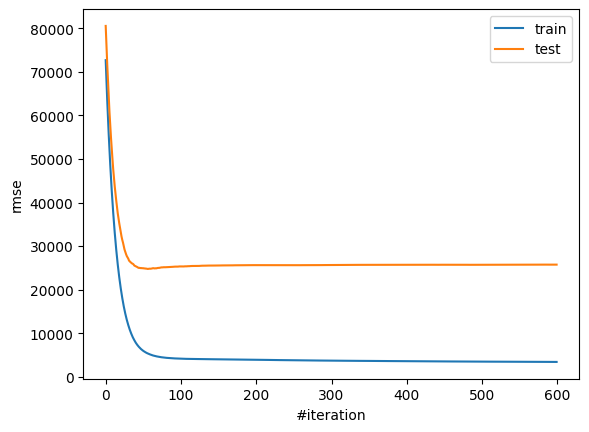

In [50]:
results = xgb_main.evals_result()
plt.plot(results["validation_0"]["rmse"], label="train")
plt.plot(results["validation_1"]["rmse"], label="test")
plt.xlabel("#iteration")
plt.ylabel("rmse")
plt.legend()
plt.savefig(learning_curve_path)
plt.show()

#### Save model

In [51]:
joblib.dump(xgb_main, estimator_path)

['inputs/housing_prices_data\\xgb_main.joblib']

## 5. Prediction

In [52]:
xgb_estimator = joblib.load(estimator_path)

In [53]:
prediction_features

,KitchenQual_Ex_sum,KitchenQual_Ex_mean,KitchenQual_Fa_sum,KitchenQual_Fa_mean,KitchenQual_Gd_sum,KitchenQual_Gd_mean,KitchenQual_TA_sum,KitchenQual_TA_mean,OverallCond_1_sum,OverallCond_1_mean,...,TotalBsmtSF_max,TotalBsmtSF_min,TotalBsmtSF_sum,GarageArea_count,GarageArea_mean,GarageArea_max,GarageArea_min,GarageArea_sum,NumYearsSinceBuilt,NumYearsSinceRemodelled
0,0,0,0,0,0,0.0,1,1.0,0,0,...,882.0,882.0,882.0,1,730.0,730.0,730.0,730.0,49,49
1,0,0,0,0,1,1.0,0,0.0,0,0,...,1329.0,1329.0,1329.0,1,312.0,312.0,312.0,312.0,52,52
2,0,0,0,0,0,0.0,1,1.0,0,0,...,928.0,928.0,928.0,1,482.0,482.0,482.0,482.0,13,12
3,0,0,0,0,1,1.0,0,0.0,0,0,...,926.0,926.0,926.0,1,470.0,470.0,470.0,470.0,12,12


In [54]:
prediction_subset.loc[:, "SalePrice"] = xgb_main.predict(prediction_features)
prediction_subset

C:\Users\ahmmu\AppData\Local\Temp\ipykernel_21576\4036902719.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  prediction_subset.loc[:, "SalePrice"] = xgb_main.predict(prediction_features)


,KitchenQual,OverallCond,OverallQual,1stFlrSF,TotalBsmtSF,GarageArea,YearBuilt,YearRemodAdd,SalePrice
0,TA,6,5,896,882.0,730.0,1961,1961,139310.062500
1,Gd,6,6,1329,1329.0,312.0,1958,1958,225366.890625
2,TA,5,5,928,928.0,482.0,1997,1998,135284.437500
3,Gd,6,6,926,926.0,470.0,1998,1998,219718.187500


In [55]:
prediction_subset[target_column].sum()

719679.56

In [56]:
prediction_subset.to_csv(prediction_subset_path, index=False)
prediction_features.to_csv(prediction_features_path, index=False)